# Assortativity

## Assortative mixing

Assortativity is a common characteristic observed in empirical networks, where nodes with similar attributes tend to be connected to each other. For instance, in social networks, individuals often interact with others of similar age, resulting in assortativity based on age.

Let's consider how to measure the level of assortativity. In an assortative network, nodes with similar attributes are more likely to be connected by an edge. Therefore, if we randomly select an edge from the network, the edge will likely connect nodes with similar attributes.

Now, let's make it more explicit about the node attributes. There are two types of attributes, namely an *enumerative attribute* and a *scalar attribute*.
An enumerative attribute is a categorical value that does not have an inherent ordering (e.g., gender).
A scalar attribute is a real numerical value that can be ordered (e.g., age).

With this in mind, let's consider step by step using the karate club network.

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


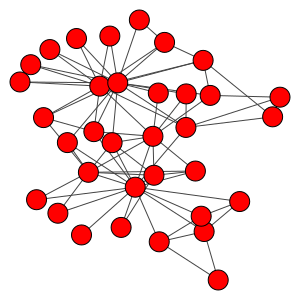

In [1]:
import networkx as nx
import igraph
import numpy as np
from scipy import sparse

# Load the adjacency matrix of the krate club network
A = nx.to_scipy_sparse_array(nx.karate_club_graph())
A.data = A.data * 0 + 1  # this converts the weighted network to unweighted network

# Convert to igraph object for visualization
src, trg, _ = sparse.find(sparse.triu(A, 1))
deg = np.array(A.sum(axis=1)).ravel()
g = igraph.Graph(edges=list(zip(src, trg)), directed=False)

igraph.plot(g, bbox=(300, 300))

## Assortativity for scalar values

When the node attribute is a scalar variable, such as age, we can quantify the similarity between the attributes of two directly connected nodes using the Pearson correlation coefficient. If the correlation is positive, we say that the network is assortative for the node attribute. Conversely, if the correlation is negative, we say that the network is disassortative.

Let us calculate the assortativity in terms of node degree, known as *degree assortativity*, for the karate club network.

In [3]:
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns


def degree_assortativity(A):
    """Compute the degree assortativity

    A: scipy.sparse adjacency matrix of a network

    Return:
    degree assortativity of the network.

    Hint:
    - use sparse.find(A) to find the node ids of the connected nodes.
    - use scipy.stats.pearsonr to compute the correlation coefficient
    """

    return


#corr = degree_assortativity(A)
#print(f"Degree assortativity = {corr}")
import networkx as nx
import igraph
import numpy as np
from scipy import sparse

# Load the adjacency matrix of the krate club network
A = nx.to_scipy_sparse_array(nx.karate_club_graph())
A.data = A.data * 0 + 1  # this converts the weighted network to unweighted network

# Convert to igraph object for visualization
src, trg, _ = sparse.find(sparse.triu(A, 1))
deg = np.array(A.sum(axis=1)).ravel()
g = igraph.Graph(edges=list(zip(src, trg)), directed=False)

igraph.plot(g, bbox=(300, 300))
g.assortativity_degree()

-0.47561309768461435

The karate club network exhibits a strong degree of disassortativity. In a degree disassortative network, nodes with a high degree are more likely to be connected to nodes with a lower degree, resulting in a star-like structure. Conversely, in a strongly assortative network, nodes with a high degree are more likely to be connected, creating a dense core within the network. This core can be identified using $k$-core decomposition.

![](https://qph.cf2.quoracdn.net/main-qimg-468957ce83120cad98d6fcb168ff8658-pjlq)

## Modularity
The karate club network represents the social connections among members of a university karate club. One unique aspect of this network is the division within the club between the instructor and the president. Each individual member has an enumerative variable about whom to support, either the instructor or the president. The attributes of each node can be obtained by

In [3]:
G = nx.karate_club_graph()
categories = np.array([d[1]["club"] for d in G.nodes(data=True)])
categories[:3], categories[-3:]

(array(['Mr. Hi', 'Mr. Hi', 'Mr. Hi'], dtype='<U7'),
 array(['Officer', 'Officer', 'Officer'], dtype='<U7'))

Let's reflect on the enumerative variable in the network visualization.

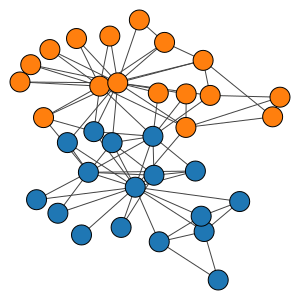

In [4]:
import seaborn as sns

category_list = np.unique(categories)
cmap = sns.color_palette()
palette = dict(zip(category_list, cmap[: len(category_list)]))
node_color = [palette[c] for c in categories]
igraph.plot(g, vertex_color=node_color, bbox=(300, 300))

We see that the network is highly assortative for who to support. Now, let's consider how to *quantify* the assortativity.
A network with strong assortativity has many edges between nodes with the same node attribute. Thus, if we randomly pick an edge from a network, two nodes connected by the edge tend to have the same node attribute.

Let's count the node attributes' co-occurrence directly connected by an edge.

In [6]:
import pandas as pd

# Get the arrays of the source and target nodes
src, trg, _ = sparse.find(A)

# When using enumerative variables, it is often convenient to construct a membership matrix U, where
# The membership matrix is an NxK matrix, where N is the number of nodes, and K is the number of categories (# of unique values the variable can take)
# U[i, k] = 1 if node i belongs to category k
# U[i, k] = 0 if node i does not belong to category k
category_list, category_ids = np.unique(categories, return_inverse=True)
rows, cols = np.arange(len(categories), dtype=int), category_ids
nrows, ncols = A.shape[0], len(category_list)
U = sparse.csr_matrix(
    (np.ones_like(rows), (rows, cols)),
    shape=(nrows, ncols),
)


# We can count the number of edges within and between the categories by multiplying
# the membership matrix to the adjacency matrix.
E = U.T @ A @ U

pd.DataFrame(E.toarray(), columns=category_list, index=category_list)

,Mr. Hi,Officer
Mr. Hi,70,11
Officer,11,64


Now, let's approach it from a statistical perspective by thinking the joint probability distribution $P(X, Y)$ of nodes' attributes, where $X$ and $Y$ represent the node attributes. To ensure that the joint probability adds up to one, let's normalize the count by dividing it by the total count.


In [7]:
total_edges = E.sum()
Pxy = E.toarray() / total_edges
pd.DataFrame(Pxy, columns=category_list, index=category_list)

,Mr. Hi,Officer
Mr. Hi,0.448718,0.070513
Officer,0.070513,0.410256


We see that the same node attributes (diagonals) have a larger co-occurrence probability than different node attributes (off-diagonals), which signals a strong assortativity.

But how large is large enough to say that the network is assortative? The network is assortative if the diagonals of the joint probability are larger than that for a network *without* assortative mixing. We can generate a network without assortative mixing by randomly shuffling the node attributes across different nodes. This shuffling breaks the assortative mixing as each node's attribute becomes independent of another node's attribute.

To be more precise, the joint probability $P(X,Y) $ in the shuffled data can be expressed as the product of the marginal probabilities $P(X)$ and $P(Y)$, denoted as $P_{\text{random}}(X,Y) = P(X)P(Y)$.

Now, let's calculate the joint probability for this random network.

In [8]:
src, trg, _ = sparse.find(A)
Px = np.bincount(category_ids[src]) / len(src)
Px

array([0.51923077, 0.48076923])

In [9]:
Pxy_random = np.outer(Px, Px)
pd.DataFrame(Pxy_random, columns=category_list, index=category_list)

,Mr. Hi,Officer
Mr. Hi,0.269601,0.249630
Officer,0.249630,0.231139


We now have all the elements to describe ***Modularity*** formally.
Modularity quantifies the tendency of connected nodes to have similar attributes more frequently than would be expected by chance. The probability that two nodes share the same attribute is obtained by summing the diagonal values, denoted as $\sum_{X}P(X,X)$. By comparing this value to the corresponding probability in a random network ($ P_{ \text{random}}(X,X)$), the modularity is formally defined as
$$
Q := \sum_{X}\left[P(X,X) - P_{\text{random}}(X, X) \right]
$$

or equivalently,

$$
 Q :=\frac{1}{2m} \sum_{i,j} \left(A_{ij} - \frac{d_i d_j}{2m} \right) \delta(x_i,x_j)
$$
where $d_i$ is the degree of node $i$, $m$ is the number of edges in the network, $x_i$ is the enumerative variable of node $i$, and $\delta$ is Kronecker's delta which is $\delta(x_i,x_j)=1$ if $x_i=x_j$ and otherwise $\delta(x_i,x_j)=0$. The modularity varies between -0.5 and 1, and a higher value implies a stronger assortativity. A negative modularity indicate disassortativity, i.e., nodes are likely to connect to other nodes with a different attribute.

In [13]:
Q = np.trace(Pxy - Pxy_random)  # trace is the sum of the diagonals


The degree assortativity is negative, suggesting that a node with high degree tends to be connected to nodes with a small degree.

## Community detection with modularity

### Girvan-Newman algorithm
Modularity is a valuable tool not only for measuring the level of assortativity in a node attribute, but also for identifying groups with strong assortativity based on the network structure. This problem can be seen as a community detection problem.

The [Girvan-Newman algorithm](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.69.026113) utilizes Modularity to identify communities within networks.
The Girvan-Newman algorithm works as follows.
1. Calculate the betweenness centrality for each edge in the network. This is known as edge betweenness.
2. Remove the edge with the highest betweenness centrality.
3. Repeat steps 1 and 2 iteratively until no edges remain in the network.
4. The iterative process breaks down the network into smaller connected components, which can be visualized as a dendrogram.
5. Treat each connected component as a community and calculate the modularity for every cut from top to bottom in the dendrogram.
7. Select the cut that achieves the highest modularity.
8. Output the communities at that cut.

![](https://ars.els-cdn.com/content/image/1-s2.0-S1470160X2100011X-gr3.jpg)

Let's implement the algorithm.

In [14]:
def calc_modularity(A, membership):
    """
    Calculate the modularity of a graph given the membership of the nodes.
    A: CSR representation of the adjacency matrix
    membership: 1D array of integers

    Return the modularity value of the given membership.

    Hint:
    - use sparse.find(A) to find the node ids of the connected nodes.
    - use np.unique to get the unique values of the membership array
    - Use a memership matrix U, where U[i, k] = 1 if node i belongs to category k, and U[i, k] = 0 otherwise
    """
    Q = ...
    return Q


def girvan_newman_algorithm(g):
    """
    Perform the Girvan-Newman algorithm on a graph.
    g: igraph Graph object

    Return the 1D array of membership of the nodes

    Hint:
    - copy the graph g.copy() before removing edges
    - use g.edge_betweenness() to get the edge betweenness
    - use g.remove_edge() to remove an edge
    - use g.components() to get the connected components
    - compute the modularity Q using the function above
    - keep track of the maximum Q and the membership array that gives the maximum Q
    """
    membership = ...
    return membership

Identify the communities by the Girvan-Newman algorithm. 

In [15]:
community_membership = girvan_newman_algorithm(g)

cmap = sns.color_palette("colorblind")
palette = dict(zip(set(community_membership), cmap[: len(set(community_membership))]))
node_color = [palette[c] for c in community_membership]
igraph.plot(g, vertex_color=node_color, bbox=(300, 300))

TypeError: 'ellipsis' object is not iterable




### Modularity maximization

The Girvan-Newman algorithm uses the Modularity as a selection criterion to pick the best partition of nodes into communities. But later, people realized that it is possible to directly *maximize* Modularity, which yields an even-more assortative grouping of nodes.

Unfortunately, the modularity maximization is an NP-hard problem. So many heuristics are developed to find communities in networks with a reasonably high modularity value. [The Louvain algorithm](https://iopscience.iop.org/article/10.1088/1742-5468/2008/10/P10008) had been the to-go method for the modularity maximization. But the algorithm is replaced by [the Laiden algorithm](https://www.nature.com/articles/s41598-019-41695-z) which runs faster and finds better communities in terms of the modularity. The Leiden algorithm is implemented in igraph.


In [16]:
community_membership = g.community_leiden("modularity").membership
community_membership = np.array(community_membership)
community_membership

array([0, 0, 0, 0, 1, 1, 1, 0, 2, 2, 1, 0, 0, 0, 2, 2, 1, 0, 2, 0, 2, 0,
       2, 3, 3, 3, 2, 3, 3, 2, 2, 3, 2, 2])

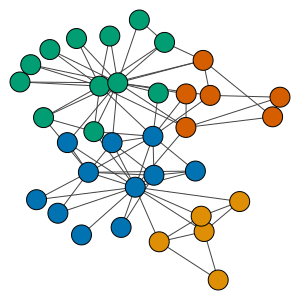

In [17]:
cmap = sns.color_palette("colorblind")
palette = dict(zip(set(community_membership), cmap[: len(set(community_membership))]))
node_color = [palette[c] for c in community_membership]
igraph.plot(g, vertex_color=node_color, bbox=(300, 300))

# Modeling communities in networks

The stochastic block model (SBM) characterizes communities in networks from a perspective of probabilities. Specifically, in SBM, every node belongs to one of the $K$ groups, where $K$ is the number of groups. A node $i$ in group $k$ is connected to another node $j$ in group $\ell$ by a probability $p_{k\ell}$ determined by the nodes' group membership (i.e., $k$ and $\ell$).

Let's implement the SBM. First, here is an example of the parameter configuration.

In [18]:
# Determine the size of the network
n_nodes = 100

# Number of groups
K = 3

# Define the membership of nodes to a group
membership = np.random.choice(K, size=n_nodes)

# Define the probability of connection between groups
P = np.array([[0.3, 0.05, 0.05], [0.05, 0.3, 0.05], [0.05, 0.05, 0.3]])

And implement the following function to generate a network with the SBM.

In [19]:
def generate_SBM_network(n_nodes, membership, P):
    """
    Generate a stochastic block model network
    n_nodes: number of nodes
    membership: 1D array of integers
    P: 2D array of connection probability between groups

    Return:
    net: CSR representation of the adjacency matrix generated by the SBM

    """
    return net


Asbm = generate_SBM_network(n_nodes, membership, P)

NameError: name 'net' is not defined

And let's visualize it

In [20]:
# Convert to igraph object for visualization
src, trg, _ = sparse.find(sparse.triu(Asbm, 1))
g = igraph.Graph(edges=list(zip(src, trg)), directed=False)

palette = dict(zip(set(membership), cmap[: len(set(membership))]))
node_color = [palette[c] for c in membership]
igraph.plot(g, layout="kk", vertex_color=node_color, bbox=(300, 300))

NameError: name 'Asbm' is not defined

#  Modularity is not a silver bullet

Modularity has some critical drawbacks ([see here](https://skewed.de/tiago/blog/modularity-harmful)). One notable limitation is the [resolution limit](https://www.pnas.org/doi/10.1073/pnas.0605965104) which states that the modularity maximization fails to find small groups even if they exist in the network.

Let's confirm the limitation by running a modularity maximization on a network with many small communities. We generate the network by using the SBM with the following configuration: 
- Number of nodes is 120
- Number of groups is 20 
- Each group consists of 6 nodes 
- Nodes in the same group are connected by an edge with probability 0.9
- Nodes in different groups are connected by an edge with probability 1/120.

Let's generate a network with the SBM and run the Leiden algorithm 

In [21]:
n_nodes = 120
K = 20
n_nodes_per_community = 6
membership = np.arange(n_nodes) // n_nodes_per_community
P = np.ones(K) * (1.0 / n_nodes) + np.eye(K) * 0.9

net = generate_SBM_network(n_nodes=n_nodes, membership=membership, P=P)

NameError: name 'net' is not defined

In [22]:
# Convert to igraph object for visualization
src, trg, _ = sparse.find(sparse.triu(net, 1))
gsbm = igraph.Graph(edges=list(zip(src, trg)))

cmap = sns.color_palette("tab20")
palette = dict(zip(np.unique(membership), cmap[: len(set(membership))]))
node_color = [palette[c] for c in membership]
igraph.plot(
    gsbm,
    layout="kk",
    vertex_color=node_color,
    bbox=(500, 500),
)

NameError: name 'net' is not defined

Run the Leiden algorithm and count the number of communities detected. Does it find more communities or less communities than the actual number of communities? 

Another issue with modularity maximization is that it can identify communities with high modularity even in random networks where no communities actually exist. This problem becomes more significant in the case of sparse networks. 

To demonstrate the problem, let's generate a network of 100 nodes with no community, in which every node is connected to any other nodes with the same probability of 0.02** 

In [23]:
n_nodes = 100
membership = ...
P = ...
net = generate_SBM_network(n_nodes, membership, P)

assert n_nodes == np.shape[0]
assert np.isclose(net.sum() / np.prod(net.shape), 0.02, atol=0.05)
assert set(membership) == 1

NameError: name 'net' is not defined

Find the communities by using the Leiden algorithm

Check out the modularity value. How high is the modularity value?

In [ ]:
calc_modularity(net, detected_membership)

How does this pseudo community look like?

In [ ]:
# Convert to igraph object for visualization
src, trg, _ = sparse.find(sparse.triu(net, 1))
gsbm = igraph.Graph(edges=list(zip(src, trg)))

cmap = sns.color_palette("tab20")
palette = dict(zip(np.unique(membership), cmap[: len(set(membership))]))
node_color = [palette[c] for c in membership]
igraph.plot(
    gsbm,
    layout="kk",
    vertex_color=node_color,
    bbox=(500, 500),
)

So why does the modularity high even for random networks, where communities do not exist. It's because we *maximize* the modularity. The modularity maximization partition nodes into an exclusive set of nodes. And there are an exponential number of possible partitions of nodes. Most partitions have a small modularity. But,  in one of the countless number of possible partitions, many edges appear within each group by a random chance. And the algorithm picks this partition with the highest (or nearly highest) modularity. 

While the modularity has many critical limitations, it is still by far the most widely used method in practice.

Alternatives to the modularity maximizations are 
- [Infomap](https://www.mapequation.org/infomap/)
- [Baysian stochastic block model](https://graph-tool.skewed.de/static/doc/demos/inference/inference.html)
- [Belief propagation method](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.107.065701)

If you are interested in the community detection problem, here are good reviews: 
1. [Community detection in graph by Santo Fortunato](https://arxiv.org/abs/0906.0612)
2. [Community detection in networks: A user guide by Santo Fortunato](https://www.cs.cornell.edu/courses/cs6241/2020sp/readings/Fortunato-2016-guide.pdf)